# Univariate Handling of Missing Data

`Univariate missing data` handling techniques operate **column-wise**, using information from a single feature
to replace missing values. These methods are simple, scalable, and commonly used in real-world ML pipelines.

---

## Automatically Selecting Imputer Parameters

Some preprocessing workflows automatically choose the best imputation strategy
(mean, median, or most frequent) using validation or cross-validation.

### Why Use Automatic Imputation Selection

- Reduces manual tuning effort  
- Improves preprocessing reliability  
- Adapts to different data distributions  
- Suitable for automated ML pipelines  

### When It Works Best

- Large datasets  
- Cross-validation–based workflows  
- Tree models and linear models  
- End-to-end pipelines  

---

## Missing Indicator

A **missing indicator** adds an additional binary feature indicating whether the original value was missing.

### Why Use a Missing Indicator

- Preserves information about missingness  
- Helps models learn patterns related to missing data  
- Especially useful when missingness is not random  

### When to Use

- More than 5% of values are missing  
- Mean or median imputation is applied  
- Missingness may influence the target  

### Models That Benefit Most

- Tree-based models  
- Logistic regression  
- Neural networks  

---

## Random Sample Imputation

Random sample imputation replaces missing values by randomly sampling from the observed (non-missing) values
of the same feature.

### Why Use Random Sample Imputation

- Preserves the original data distribution  
- Maintains variance better than mean or median imputation  
- Reduces bias introduced by constant values  

### When to Use

- Continuous numerical features  
- Missing At Random (MAR) scenarios  
- When distribution preservation is important  

### Models That Benefit Most

- Random Forest  
- XGBoost  
- Distance-based models such as k-NN  

---

## Summary

Univariate missing data handling techniques are simple yet powerful.
Automatic imputation selection improves robustness, missing indicators preserve valuable information,
and random sample imputation maintains data distribution. Choosing the right technique depends on
the nature of missingness, feature type, and the model being used.


### Automatically Select Imputer Parameters

In [1]:
%%capture
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn


In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

In [4]:
df = pd.read_csv('Titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.drop(columns=['PassengerId','Name','Ticket','Cabin'],inplace=True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [6]:
X = df.drop(columns=['Survived'])
y = df['Survived']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
30,1,male,40.0,0,0,27.7208,C
10,3,female,4.0,1,1,16.7000,S
873,3,male,47.0,0,0,9.0000,S
182,3,male,9.0,4,2,31.3875,S
876,3,male,20.0,0,0,9.8458,S


In [7]:
numerical_features = ['Age', 'Fare']
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = ['Embarked', 'Sex']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe',OneHotEncoder(handle_unknown='ignore'))
])

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [9]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

In [10]:
from sklearn import set_config

set_config(display='diagram')
clf

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [11]:
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'preprocessor__cat__imputer__strategy': ['most_frequent', 'constant'],
    'classifier__C': [0.1, 1.0, 10, 100]
}

grid_search = GridSearchCV(clf, param_grid, cv=10)

In [12]:
grid_search.fit(X_train, y_train)

print(f"Best params:")
print(grid_search.best_params_)

Best params:
{'classifier__C': 1.0, 'preprocessor__cat__imputer__strategy': 'most_frequent', 'preprocessor__num__imputer__strategy': 'mean'}


In [13]:
import pandas as pd

cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values("mean_test_score", ascending=False)
cv_results[['param_classifier__C','param_preprocessor__cat__imputer__strategy','param_preprocessor__num__imputer__strategy','mean_test_score']]

,param_classifier__C,param_preprocessor__cat__imputer__strategy,param_preprocessor__num__imputer__strategy,mean_test_score
7,1.0,constant,median,0.787852
6,1.0,constant,mean,0.787852
5,1.0,most_frequent,median,0.787852
4,1.0,most_frequent,mean,0.787852
11,10.0,constant,median,0.787852
10,10.0,constant,mean,0.787852
9,10.0,most_frequent,median,0.787852
8,10.0,most_frequent,mean,0.787852
12,100.0,most_frequent,mean,0.787852
13,100.0,most_frequent,median,0.787852


### Missing Indicator

In [14]:
from sklearn.impute import MissingIndicator,SimpleImputer

In [15]:
df = pd.read_csv('Titanic.csv',usecols=['Age','Fare','Survived'])
df.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [16]:
X = df.drop(columns=['Survived'])
y = df['Survived']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)
X_train.head()

,Age,Fare
30,40.0,27.7208
10,4.0,16.7000
873,47.0,9.0000
182,9.0,31.3875
876,20.0,9.8458


In [17]:
si = SimpleImputer()
X_train_trf = si.fit_transform(X_train)
X_test_trf = si.transform(X_test)
X_train_trf

array([[ 40.        ,  27.7208    ],
       [  4.        ,  16.7       ],
       [ 47.        ,   9.        ],
       ...,
       [ 71.        ,  49.5042    ],
       [ 29.78590426, 221.7792    ],
       [ 29.78590426,  25.925     ]], shape=(712, 2))

In [18]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

clf.fit(X_train_trf,y_train)

y_pred = clf.predict(X_test_trf)

from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.6145251396648045

In [19]:
mi = MissingIndicator()

mi.fit(X_train)

,missing_values,nan
,features,'missing-only'
,sparse,'auto'
,error_on_new,True


In [20]:
mi.features_

array([0])

In [21]:
X_train_missing = mi.transform(X_train)
X_train_missing

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [

In [22]:
X_test_missing = mi.transform(X_test)
X_test_missing

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [

In [23]:
X_train['Age_NA'] = X_train_missing

In [24]:
X_test

,Age,Fare
707,42.0,26.2875
37,21.0,8.0500
615,24.0,65.0000
169,28.0,56.4958
68,17.0,7.9250
...,...,...
89,24.0,8.0500
80,22.0,9.0000
846,NaN,69.5500
870,26.0,7.8958


In [25]:
X_test['Age_NA'] = X_test_missing

In [26]:
X_train

,Age,Fare,Age_NA
30,40.0,27.7208,False
10,4.0,16.7000,False
873,47.0,9.0000,False
182,9.0,31.3875,False
876,20.0,9.8458,False
...,...,...,...
534,30.0,8.6625,False
584,NaN,8.7125,True
493,71.0,49.5042,False
527,NaN,221.7792,True


In [27]:
si = SimpleImputer()

X_train_trf2 = si.fit_transform(X_train)
X_test_trf2 = si.transform(X_test)

In [28]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

clf.fit(X_train_trf2,y_train)

y_pred = clf.predict(X_test_trf2)

from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.6312849162011173

In [29]:
#Using Scikit-Learn

si = SimpleImputer(add_indicator=True)
X_train = si.fit_transform(X_train)
X_test = si.transform(X_test)
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

clf.fit(X_train_trf2,y_train)

y_pred = clf.predict(X_test_trf2)

from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.6312849162011173

### Random Sample Imputation

In [60]:
df = pd.read_csv('Titanic.csv',usecols=['Age','Fare','Survived'])
df.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [32]:
df.isnull().mean() * 100

Survived     0.00000
Age         19.86532
Fare         0.00000
dtype: float64

In [33]:
X = df.drop(columns=['Survived'])
y = df['Survived']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)
X_train

,Age,Fare
30,40.0,27.7208
10,4.0,16.7000
873,47.0,9.0000
182,9.0,31.3875
876,20.0,9.8458
...,...,...
534,30.0,8.6625
584,NaN,8.7125
493,71.0,49.5042
527,NaN,221.7792


In [34]:
X_train['Age_imputed'] = X_train['Age']
X_test['Age_imputed'] = X_test['Age']

In [35]:
X_test.tail()

,Age,Fare,Age_imputed
89,24.0,8.0500,24.0
80,22.0,9.0000,22.0
846,NaN,69.5500,NaN
870,26.0,7.8958,26.0
251,29.0,10.4625,29.0


In [36]:
X_train['Age_imputed'][X_train['Age_imputed'].isnull()] = X_train['Age'].dropna().sample(X_train['Age'].isnull().sum()).values
X_test['Age_imputed'][X_test['Age_imputed'].isnull()] = X_train['Age'].dropna().sample(X_test['Age'].isnull().sum()).values

C:\Users\Msi Laptop\AppData\Local\Temp\ipykernel_19836\3090101260.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  X_train['Age_imputed'][X_train['Age_imputed'].isnull()] = X_train['Age'].dropna().sample(X_train['Age'].isnull().sum()).val

In [37]:
X_train['Age'].dropna().sample(X_train['Age'].isnull().sum()).values

array([32.  , 24.  , 44.  , 36.  , 36.  , 23.  ,  9.  , 47.  , 22.  ,
       42.  , 71.  , 28.  , 25.  , 24.  , 51.  , 45.  , 17.  , 20.  ,
       54.  , 19.  , 23.  , 47.  , 39.  , 24.  , 50.  , 30.  ,  6.  ,
        2.  , 19.  , 42.  , 28.  , 37.  , 47.  , 29.  , 27.  , 40.  ,
       47.  , 16.  , 58.  , 27.  , 38.  , 32.  , 35.  , 64.  , 25.  ,
       47.  , 36.  , 54.  , 49.  , 45.5 , 27.  , 28.  ,  0.67, 21.  ,
       42.  , 38.  , 52.  , 51.  , 31.  , 25.  , 24.  , 28.  , 21.  ,
        9.  , 22.  , 56.  , 24.  , 33.  ,  7.  , 46.  , 29.  , 46.  ,
       31.  , 70.  , 23.  , 21.  , 42.  , 61.  , 23.  ,  4.  , 65.  ,
       22.  , 54.  , 48.  ,  9.  , 33.  ,  6.  , 16.  , 27.  , 54.  ,
       54.  , 25.  , 33.  , 28.5 , 32.  , 45.  , 32.  , 42.  , 24.  ,
       27.  , 27.  ,  9.  , 38.  , 34.  , 40.  , 32.  , 40.  , 34.  ,
       22.  , 34.  , 11.  , 30.  , 32.  , 33.  , 40.  ,  4.  , 36.  ,
       39.  , 62.  , 20.  , 17.  , 30.  , 28.  , 16.  ,  1.  , 34.  ,
        3.  , 34.  ,

In [38]:
X_train['Age'].isnull().sum()
148
X_train

,Age,Fare,Age_imputed
30,40.0,27.7208,40.0
10,4.0,16.7000,4.0
873,47.0,9.0000,47.0
182,9.0,31.3875,9.0
876,20.0,9.8458,20.0
...,...,...,...
534,30.0,8.6625,30.0
584,NaN,8.7125,33.0
493,71.0,49.5042,71.0
527,NaN,221.7792,9.0


In [40]:
import seaborn as sns

C:\Users\Msi Laptop\AppData\Local\Temp\ipykernel_19836\2642582470.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_train['Age'],label='Original',hist=False)
C:\Users\Msi Laptop\AppData\Local\Temp\ipykernel_19836\2642582470.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplo

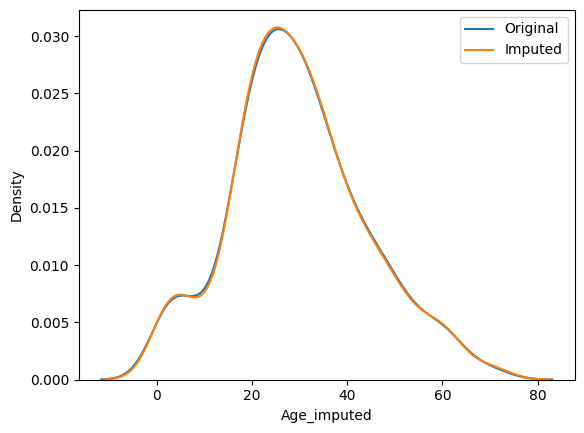

In [41]:
sns.distplot(X_train['Age'],label='Original',hist=False)
sns.distplot(X_train['Age_imputed'],label = 'Imputed',hist=False)

plt.legend()
plt.show()

In [42]:
print('Original variable variance: ', X_train['Age'].var())
print('Variance after random imputation: ', X_train['Age_imputed'].var())

Original variable variance:  204.34951339046142
Variance after random imputation:  204.842628394096


In [43]:
X_train[['Fare', 'Age', 'Age_imputed']].cov()

,Fare,Age,Age_imputed
Fare,2368.246832,71.512440,54.997767
Age,71.512440,204.349513,204.349513
Age_imputed,54.997767,204.349513,204.842628


<Axes: >

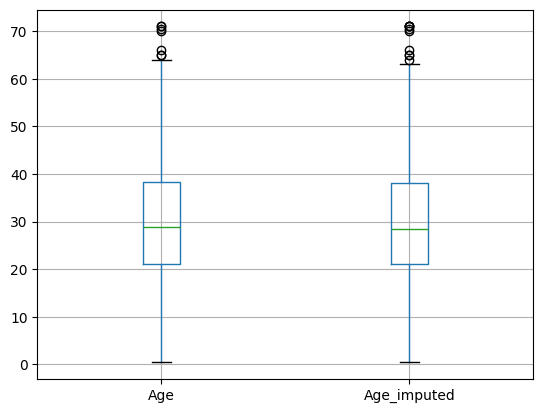

In [44]:
X_train[['Age', 'Age_imputed']].boxplot()

In [47]:
observation = X_train.iloc[0]  # pick any row
sampled_value = X_train['Age'].dropna().sample(
    1,
    random_state=int(observation['Fare'])
)


In [48]:
sampled_value = X_train['Age'].dropna().sample(1, random_state=int(observation['Fare']))
data = pd.read_csv('Housing.csv',usecols=['GarageQual','FireplaceQu', 'SalePrice'])
data.head()

,FireplaceQu,GarageQual,SalePrice
0,NaN,TA,208500
1,TA,TA,181500
2,TA,TA,223500
3,Gd,TA,140000
4,TA,TA,250000


In [49]:
data.isnull().mean() * 100

FireplaceQu    47.260274
GarageQual      5.547945
SalePrice       0.000000
dtype: float64

In [50]:
X = data
y = data['SalePrice']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [51]:
X_train['GarageQual_imputed'] = X_train['GarageQual']
X_test['GarageQual_imputed'] = X_test['GarageQual']

X_train['FireplaceQu_imputed'] = X_train['FireplaceQu']
X_test['FireplaceQu_imputed'] = X_test['FireplaceQu']

In [52]:
X_train.sample(5)

,FireplaceQu,GarageQual,SalePrice,GarageQual_imputed,FireplaceQu_imputed
477,Gd,TA,380000,TA,Gd
178,Gd,TA,501837,TA,Gd
791,TA,TA,146800,TA,TA
695,TA,TA,176000,TA,TA
414,TA,TA,228000,TA,TA


In [53]:
X_train['GarageQual_imputed'][X_train['GarageQual_imputed'].isnull()] = X_train['GarageQual'].dropna().sample(X_train['GarageQual'].isnull().sum()).values
X_test['GarageQual_imputed'][X_test['GarageQual_imputed'].isnull()] = X_train['GarageQual'].dropna().sample(X_test['GarageQual'].isnull().sum()).values

X_train['FireplaceQu_imputed'][X_train['FireplaceQu_imputed'].isnull()] = X_train['FireplaceQu'].dropna().sample(X_train['FireplaceQu'].isnull().sum()).values
X_test['FireplaceQu_imputed'][X_test['FireplaceQu_imputed'].isnull()] = X_train['FireplaceQu'].dropna().sample(X_test['FireplaceQu'].isnull().sum()).values

C:\Users\Msi Laptop\AppData\Local\Temp\ipykernel_19836\856878696.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  X_train['GarageQual_imputed'][X_train['GarageQual_imputed'].isnull()] = X_train['GarageQual'].dropna().sample(X_train['Garag

In [54]:
temp = pd.concat(
        [
            X_train['GarageQual'].value_counts() / len(X_train['GarageQual'].dropna()),
            X_train['GarageQual_imputed'].value_counts() / len(X_train)
        ],
        axis=1)

temp.columns = ['original', 'imputed']

In [55]:
temp

,original,imputed
TA,0.951043,0.952911
Fa,0.037171,0.035103
Gd,0.009973,0.010274
Po,0.000907,0.000856
Ex,0.000907,0.000856


In [56]:
temp = pd.concat(
        [
            X_train['FireplaceQu'].value_counts() / len(X_train['FireplaceQu'].dropna()),
            X_train['FireplaceQu_imputed'].value_counts() / len(df)
        ],
        axis=1)

temp.columns = ['original', 'imputed']

temp

,original,imputed
Gd,0.494272,0.649832
TA,0.412439,0.538721
Fa,0.040917,0.054994
Po,0.027823,0.035915
Ex,0.024550,0.031425


C:\Users\Msi Laptop\AppData\Local\Temp\ipykernel_19836\1827688635.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_train[X_train['FireplaceQu'] == category]['SalePrice'],hist=False,label=category)
C:\Users\Msi Laptop\AppData\Local\Temp\ipykernel_19836\1827688635.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147

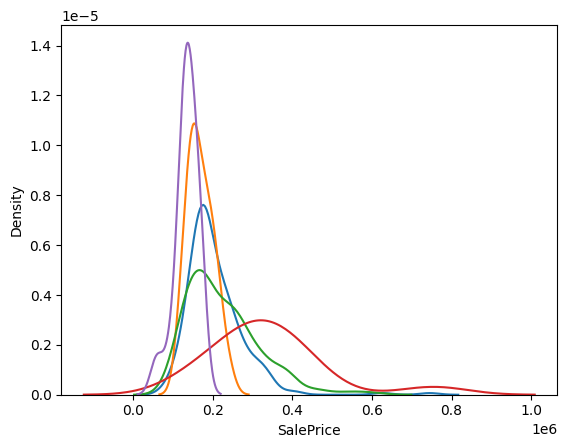

In [57]:
for category in X_train['FireplaceQu'].dropna().unique():
    sns.distplot(X_train[X_train['FireplaceQu'] == category]['SalePrice'],hist=False,label=category)
plt.show()

C:\Users\Msi Laptop\AppData\Local\Temp\ipykernel_19836\722808554.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_train[X_train['FireplaceQu_imputed'] == category]['SalePrice'],hist=False,label=category)
C:\Users\Msi Laptop\AppData\Local\Temp\ipykernel_19836\722808554.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/d

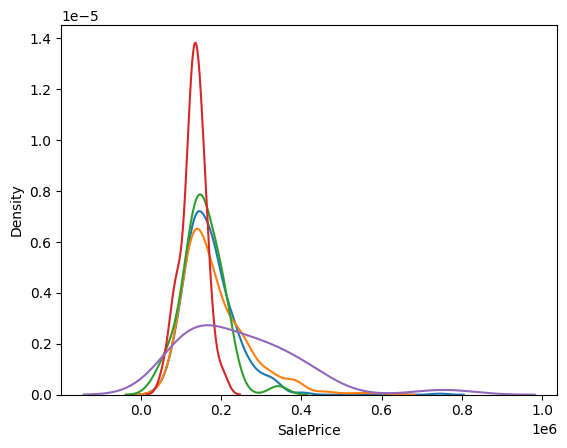

In [58]:
for category in X_train['FireplaceQu_imputed'].dropna().unique():
    sns.distplot(X_train[X_train['FireplaceQu_imputed'] == category]['SalePrice'],hist=False,label=category)
plt.show()